In [1]:
%matplotlib notebook

import numpy as np
from scipy.integrate import solve_ivp
from numpy import pi
import matplotlib.pyplot as plt
from qutip import *
from typing import Tuple

from basics import *
from hybrid_matrix_elements import *
from atomic_physics import *

In [2]:
def projector(dimensions, state_index):
    pj = np.zeros((dimensions, dimensions),dtype=int)
    pj[state_index,state_index] = 1
    return Qobj(pj)

## Experiment Parameters

In [3]:
p_ge = 75e-3  # W
p_er = 45e-3  # W
w_ge = 15e-6  # mchroem
w_er = 5e-6  # m
pol_ge = SphericalVector([1,0,0])  # Z polarized
pol_er = SphericalVector([1,0,0])  # Z polarized
k_ar = SphericalVector([1,0,0], spherical_basis=False)  # X polarized
nr = 52  # Target Rydberg State
phi_ge = 0  # phase on 684nm field
phi_er = 0  # phase of 595nm field

bias_B = 5 * gauss # bias field in the z-direction

# Laser detunings
detuning = 2*pi*80.0e6  # Detuning from the ground-excited (F'=6) transition
# detuning = 2*pi*85.1e6
# Simulated AC start shifts
dAC = 0  # To target |nrP3/2,1/2> state
dAC = 0  # To target |nrP3/2,-1/2> state
delta = np.array([detuning - DET for DET in DHF])  # Intermediate detunings for each state
little_delta = zeeman_R(bias_B, nr, -1/2)+dAC  # two-photon detuning from unperturbed |nrP3/2> level

# Lists of quantum numbers being tracked
fs = range(1,7,1)  # Intermediate f levels
mfs = [-2,-1,0,1,2]  # Intermediate mf states being considered. Other mf's are uncoupled from light fields
mrs = np.arange(-3/2,3/2+1,1)  # Rydberg Zeeman states

## Atomic Physics constants

In [4]:
gamma_e = gamma_5D
n_eff = nr - defect_p_3o2(nr)
gamma_r = 1/ryd_lifetime_np3o2(n_eff, 300)

# Simulate Dynamics Using Qutip
## Define Hamiltonian and State Vector

In [5]:
dim = 1+28+4+1 # 1 ground, 28 excited, 4 rydberg, 1 aux depumped state
def find(f,mf):
    if abs(mf) > f:
        return -1
    if f == 1:
        return 3*f+mf-1
    else:
        return 5*f+mf-4
ryd_ind = lambda mr: int(mr + 3/2)+29
aux_ind = dim-1

# Initialize hamiltonian and state
H = np.zeros((dim,dim),dtype=complex)
psi_0 = basis(dim,0)


for f in fs:
    for mf in mfs:
        if abs(mf) > f:
            continue
        # print(f"|f,mf = {f,mf}>, ind = {find(f,mf)}")
        # Ground - Excited Rabi frequencies
        H[0,find(f,mf)] = q_rabi_frequency(p_ge, w_ge, pol_ge, k_ar, q_rad_int, f, mf, phi_ge)/2
        H[find(f,mf),0] = H[0,find(f,mf)].conjugate()
        # Detuning from intermediate state
        # print(delta[f])
        H[find(f,mf),find(f,mf)] = delta[f] - zeeman_e(bias_B, f, mf)
        
        # Excited - Rydberg Rabi frequencies
        for mr in mrs:
            #print(mr,ryd_ind(mr))
            H[find(f,mf),ryd_ind(mr)] = d_rabi_frequency(p_er, w_er, pol_er, nr, f, mf, mr, phi_er)/2
            H[ryd_ind(mr),find(f,mf)] = H[find(f,mf),ryd_ind(mr)].conjugate()
            H[ryd_ind(mr),ryd_ind(mr)] = little_delta - zeeman_R(bias_B, nr, mr)

## Define Decay Matrices

In [6]:
def destructor(dimensions: int, ind: int, rate: float, branching: float = 1) -> Tuple[Qobj,Qobj]:
    """
    Creates an annihilation operator compatible with a system of the specified dimensions, where the 0th state is the ground 
    state.
    Args:
        dimensions: number of dimensions in the Hilbert Space
        ind: index or indeces of the states which this operator acts on
        rate: the decay rate of this state.
        branching: fraction of branching ratio that decays into ground state, rest of ratio falls into depumped aux state
        
    Returns:
        Qobjs representing an annihilation operators that takes the state (or states) specified by ind to the pumped ground
            state and depumped ground states
    """
    nd_op_pumped = np.zeros((dimensions, dimensions), dtype=complex)
    nd_op_pumped[0,ind] = branching*np.sqrt(rate)  # Decay that falls into qubit ground state
    
    nd_op_depumped = np.zeros((dimensions, dimensions), dtype=complex)
    nd_op_depumped[aux_ind,ind] = (1-branching)*np.sqrt(rate)  # Decay that doesn't fall into pumped state (eg other zeeman states)
    return Qobj(nd_op_pumped), Qobj(nd_op_depumped)

collapse = []
for f in fs:
    for mf in mfs:
        if find(f,mf) == -1:
            continue
        branching = 0.1
        collapse += destructor(dim, find(f, mf), gamma_e, branching)
for mr in mrs:
    branching = 0.2
    collapse += destructor(dim, ryd_ind(mr), gamma_r, branching)

## Simulate Oscillations for many detunings

In [7]:
H_cp = H.copy()
t_list = np.linspace(0, 6e-6, 1000)
detunings = np.linspace(-130e6, 130e6, 81)
Ps = np.zeros((dim, len(detunings), len(t_list)),dtype = float)

for i, det in enumerate(detunings):
    for mr in mrs:
        H_cp[ryd_ind(mr), ryd_ind(mr)] = H[ryd_ind(mr), ryd_ind(mr)] + det
    
    H_qtip = Qobj(H_cp)
    result = mesolve(H_qtip, psi_0, t_list, collapse, [], options = Options(nsteps=50000))
    Ps[:,i,:] = expect([projector(dim,d) for d in range(dim)],result.states)

<IPython.core.display.Javascript object>


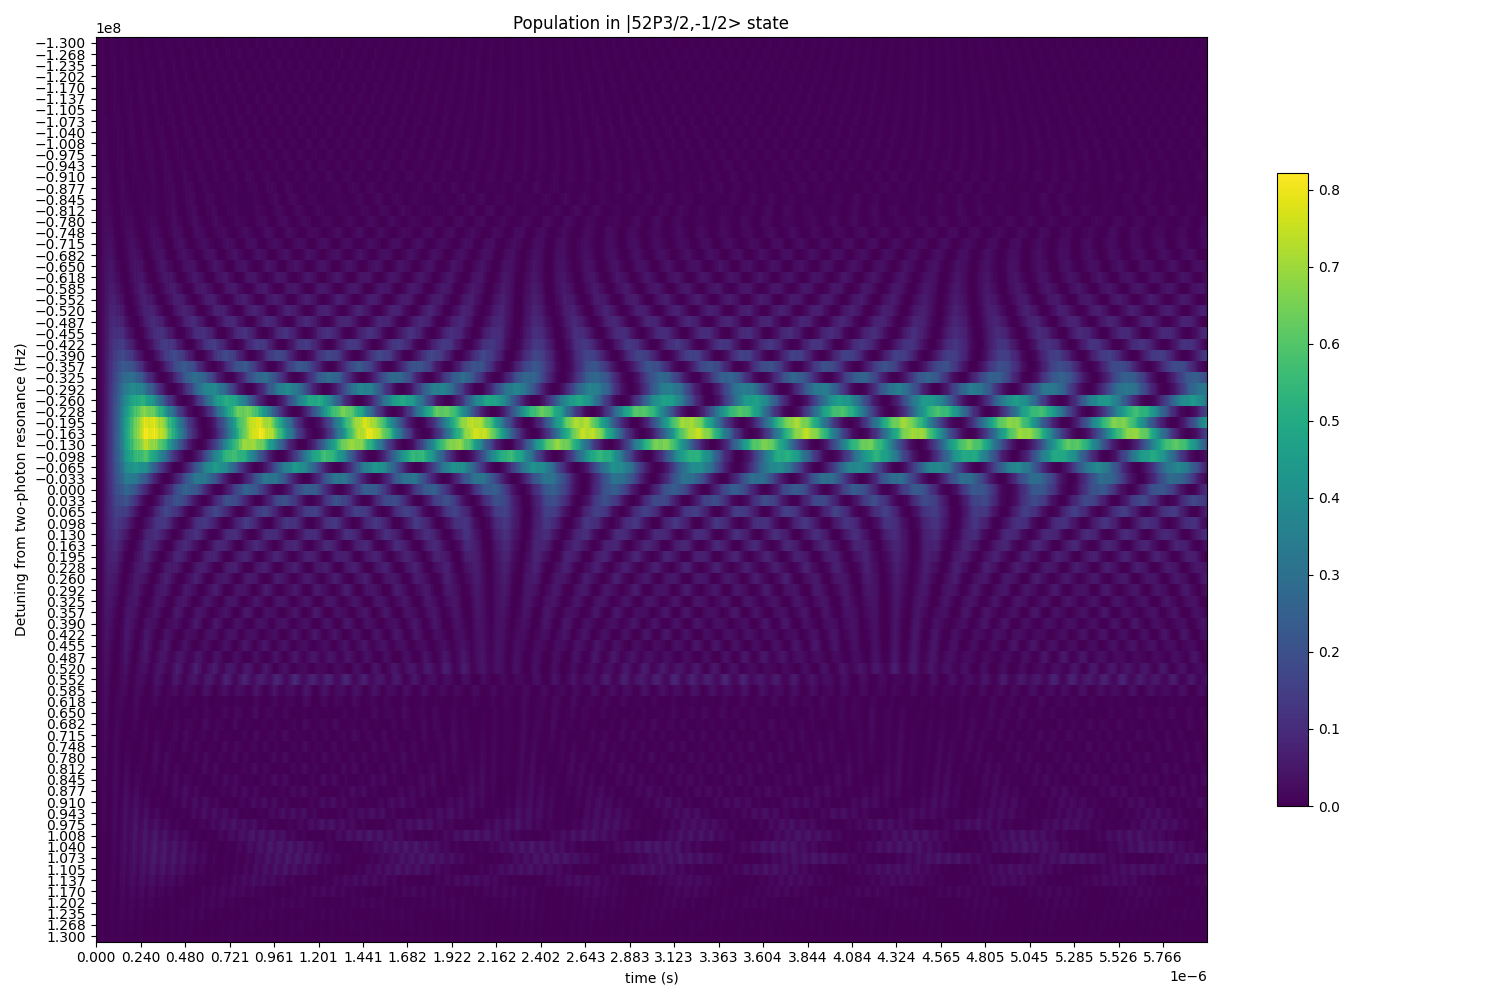

In [8]:
PT = Ps[ryd_ind(-1/2)]
fig,ax = plt.subplots(1,1,figsize=(15,10))
detuning_steps = detunings[1] - detunings[0]
ts = t_list
ts_steps = ts[1] - ts[0]
extent = [
    min(ts - ts_steps / 2),  # left
    max(ts + ts_steps / 2),  # right
    max(detunings + detuning_steps / 2),  # bottom
    min(detunings - detuning_steps / 2)   # top
]
im = ax.imshow(PT, interpolation='none', aspect='auto', extent=extent)
ax.set_xlabel("time (s)")
ax.set_ylabel("Detuning from two-photon resonance (Hz)")
ax.set_xticks(ts[::40])
ax.set_yticks(detunings)
ax.set_title(f"Population in |{nr}P3/2,-1/2> state")
fig.tight_layout()
fig.colorbar(im, ax=ax, use_gridspec=True, shrink=.7)
fig.show()
#fig.savefig("PiPulsetom1.png")

<IPython.core.display.Javascript object>


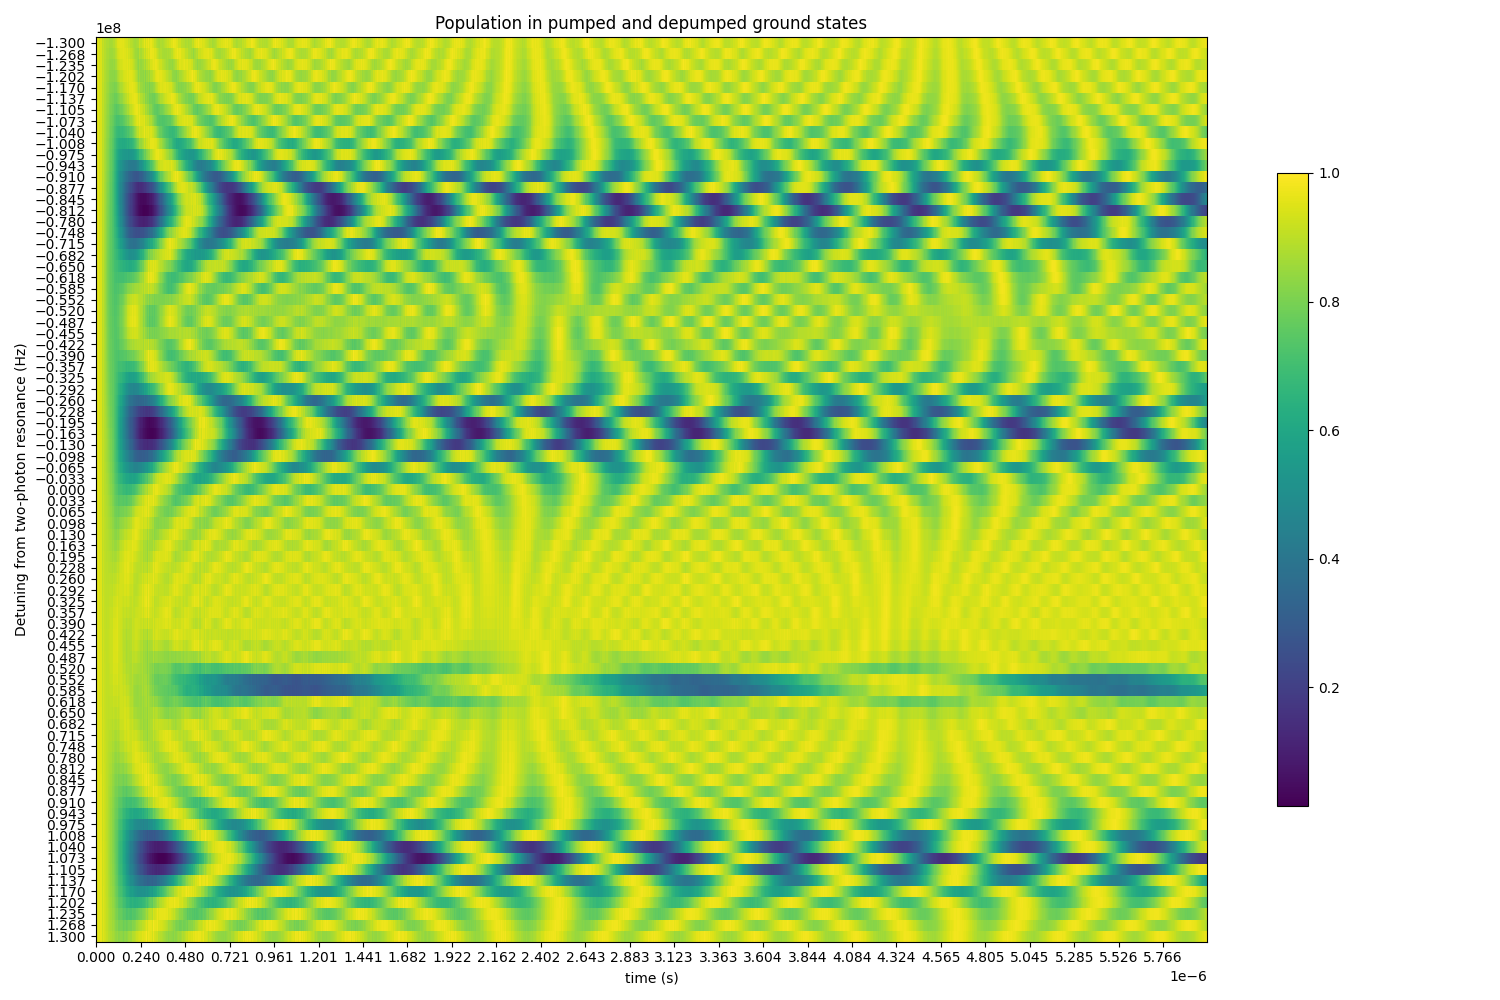

In [9]:
PT = Ps[0] + Ps[aux_ind]
fig,ax = plt.subplots(1,1,figsize=(15,10))
detuning_steps = detunings[1] - detunings[0]
ts = t_list
ts_steps = ts[1] - ts[0]
extent = [
    min(ts - ts_steps / 2),  # left
    max(ts + ts_steps / 2),  # right
    max(detunings + detuning_steps / 2),  # bottom
    min(detunings - detuning_steps / 2)   # top
]
im = ax.imshow(PT, interpolation='none', aspect='auto', extent=extent)
ax.set_xlabel("time (s)")
ax.set_ylabel("Detuning from two-photon resonance (Hz)")
ax.set_xticks(ts[::40])
ax.set_yticks(detunings)
ax.set_title(f"Population in pumped and depumped ground states")
fig.tight_layout()
fig.colorbar(im, ax=ax, use_gridspec=True, shrink=.7)
fig.show()
#fig.savefig("PiPulsetom1.png")

<IPython.core.display.Javascript object>


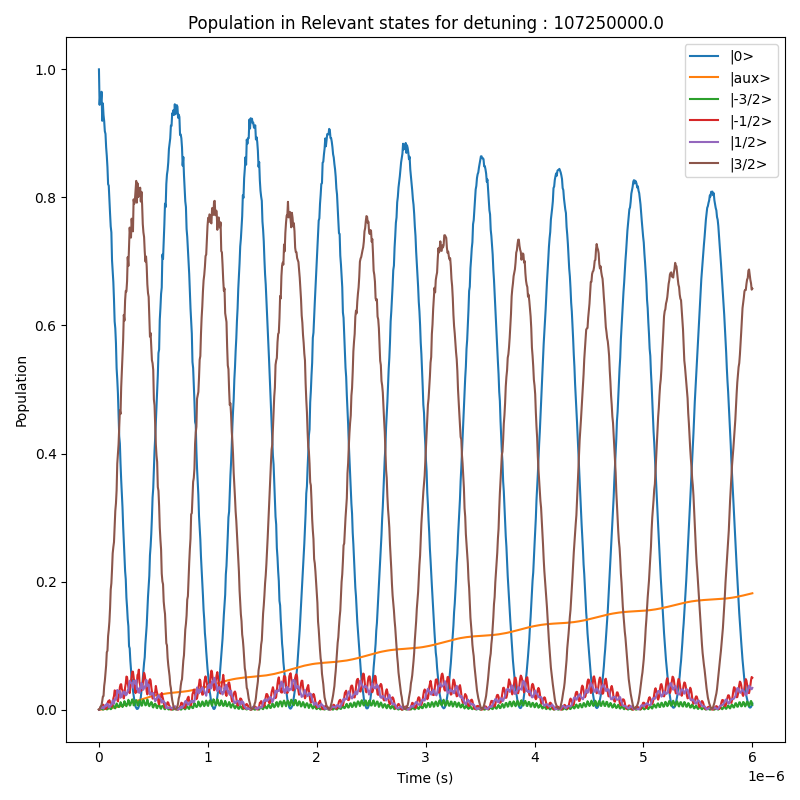

In [19]:
fig, ax = plt.subplots(1,1, figsize=(8,8))

det_choice = 1.073e8 # MHz
det_ind = np.where(abs(detunings-det_choice) == min(abs(detunings-det_choice)))[0][0]

ax.plot(t_list, Ps[0, det_ind, :], label=f"|0>")
ax.plot(t_list, Ps[aux_ind, det_ind, :], label=f"|aux>")
for mr in mrs:
    ax.plot(t_list, Ps[ryd_ind(mr), det_ind, :], label=f"|{int(2*mr)}/2>")
ax.set_ylabel("Population")
ax.set_xlabel("Time (s)")
ax.set_title(f"Population in Relevant states for detuning : {detunings[det_ind]}")
ax.legend()

fig.tight_layout()
fig.show()

<IPython.core.display.Javascript object>


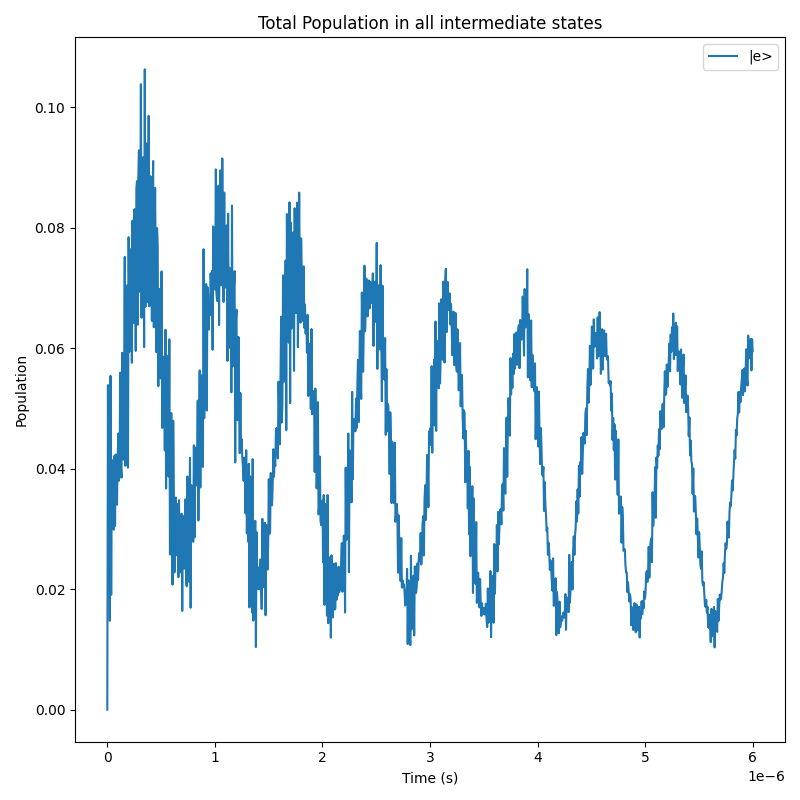

In [20]:
fig, ax = plt.subplots(1,1, figsize=(8,8))

det_ind = np.where(abs(detunings-det_choice) == min(abs(detunings-det_choice)))[0][0]

finds = range(find(1,-1),find(6,2)+1)

ax.plot(t_list, np.array([Ps[ind, det_ind, :] for ind in finds]).sum(0), label=f"|e>")
ax.set_ylabel("Population")
ax.set_xlabel("Time (s)")
ax.set_title("Total Population in all intermediate states")
ax.legend()

fig.tight_layout()
fig.show()